## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [1]:
import os
import keras
import matplotlib.pyplot as plt
%matplotlib inline


# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95
EASY_STOP=[5,10, 25]

In [7]:
from keras.callbacks import EarlyStopping

results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for es in EASY_STOP:
    earlystop = EarlyStopping(monitor="val_acc", 
                          patience=es, 
                          verbose=1
                          )
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with ES = %.6f" % (es))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[earlystop])
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-es-%s" % str(es)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

W0723 23:02:25.502076  9744 deprecation_wrapper.py:119] From e:\using\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0723 23:02:25.504076  9744 deprecation_wrapper.py:119] From e:\using\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0723 23:02:25.527077  9744 deprecation_wrapper.py:119] From e:\using\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0723 23:02:25.529078  9744 deprecation_wrapper.py:119] From e:\using\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0723 23:02:25.531077  9744 deprecation_wrapper.py:1

Experiment with ES = 5.000000


W0723 23:02:25.851096  9744 deprecation_wrapper.py:119] From e:\using\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0723 23:02:25.968102  9744 deprecation.py:323] From C:\Users\Sanga\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 63us/step - loss: 2.2373 - acc: 0.2637 - val_loss: 2.1964 - val_acc: 0.3120
Epoch 2/50
50000/50000 [==============================] - 2s 45us/step - loss: 1.7486 - acc: 0.3887 - val_loss: 1.8092 - val_acc: 0.3791
Epoch 3/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.6187 - acc: 0.4316 - val_loss: 1.6990 - val_acc: 0.4035
Epoch 4/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.5413 - acc: 0.4615 - val_loss: 1.6427 - val_acc: 0.4261
Epoch 5/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.4870 - acc: 0.4814 - val_loss: 1.6075 - val_acc: 0.4392
Epoch 6/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.4399 - acc: 0.4986 - val_loss: 1.5545 - val_acc: 0.4536
Epoch 7/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.4013 - acc: 0.5122 - val_loss: 1.5450 - val_acc

50000/50000 [==============================] - 2s 47us/step - loss: 1.4977 - acc: 0.4788 - val_loss: 1.6015 - val_acc: 0.4389
Epoch 6/50
50000/50000 [==============================] - 2s 45us/step - loss: 1.4515 - acc: 0.4952 - val_loss: 1.5699 - val_acc: 0.4483
Epoch 7/50
50000/50000 [==============================] - 2s 45us/step - loss: 1.4108 - acc: 0.5106 - val_loss: 1.5510 - val_acc: 0.4505
Epoch 8/50
50000/50000 [==============================] - 2s 45us/step - loss: 1.3751 - acc: 0.5242 - val_loss: 1.5318 - val_acc: 0.4625
Epoch 9/50
50000/50000 [==============================] - 2s 45us/step - loss: 1.3427 - acc: 0.5352 - val_loss: 1.5145 - val_acc: 0.4676
Epoch 10/50
50000/50000 [==============================] - 2s 45us/step - loss: 1.3111 - acc: 0.5449 - val_loss: 1.5074 - val_acc: 0.4672
Epoch 11/50
50000/50000 [==============================] - 2s 45us/step - loss: 1.2836 - acc: 0.5545 - val_loss: 1.4986 - val_acc: 0.4772
Epoch 12/50
50000/50000 [=========================

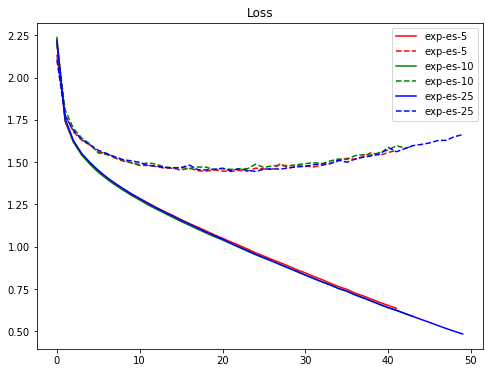

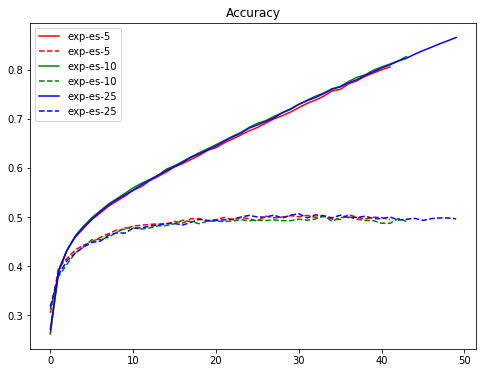

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()